In [ ]:

# get dataset from Quora in tsv format

import requests

r = requests.get("http://qim.fs.quoracdn.net/quora_duplicate_questions.tsv")
with open("QuoraDuplicationDataset.tsv", "wb") as f:
    f.write(r.content)

            id  ... is_duplicate
0            0  ...            0
1            1  ...            0
2            2  ...            0
3            3  ...            0
4            4  ...            0
...        ...  ...          ...
404285  404285  ...            0
404286  404286  ...            1
404287  404287  ...            0
404288  404288  ...            0
404289  404289  ...            0

[404290 rows x 4 columns]


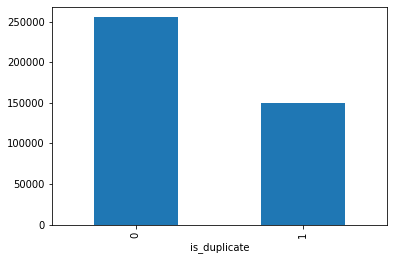

In [ ]:
# read dataset

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv('QuoraDuplicationDataset.tsv', sep = "\t")
df.drop(['qid1','qid2'], axis=1, inplace=True)
print(df)
df.dropna(axis=0, inplace=True)
df.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
# apply preprocessing techniques

import re

def convert_to_lower_case(text):
    
    return text.lower()

def remove_punctuation_and_white_space(text):

    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(' +', ' ', text)

    return text

def general_removal(text):

    text = re.sub("\'s", " ", text)
    text = re.sub(" whats ", " what is ", text, flags=re.IGNORECASE)
    text = re.sub("\'ve", " have ", text)
    text = re.sub("can't", "can not", text)
    text = re.sub("n't", " not ", text)
    text = re.sub("i'm", "i am", text, flags=re.IGNORECASE)
    text = re.sub("\'re", " are ", text)
    text = re.sub("\'d", " would ", text)
    text = re.sub("\'ll", " will ", text)
    text = re.sub("e\.g\.", " eg ", text, flags=re.IGNORECASE)
    text = re.sub("b\.g\.", " bg ", text, flags=re.IGNORECASE)
    text = re.sub("(\d+)(kK)", " \g<1>000 ", text)
    text = re.sub("e-mail", " email ", text, flags=re.IGNORECASE)
    text = re.sub('(?<=[0-9])\,(?=[0-9])', "", text)
    text = re.sub('\$', " dollar ", text)
    text = re.sub('\%', " percent ", text)
    text = re.sub('\&', " and ", text)

    return text

def preprocessing(text):
    text = convert_to_lower_case(text)
    text = remove_punctuation_and_white_space(text)
    text = general_removal(text)
    return text

df['question1'] = df['question1'].apply(preprocessing)
df['question2'] = df['question2'].apply(preprocessing)
print(df['question1'])


In [ ]:
# bag of words implementation

from sklearn.feature_extraction.text import CountVectorizer
import scipy
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, classification_report, accuracy_score

count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(pd.concat((df['question1'],df['question2'])).unique())
trainq1_trans = count_vect.transform(df['question1'].values)
trainq2_trans = count_vect.transform(df['question2'].values)
labels = df['is_duplicate'].values
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
y = labels
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)

xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model.predict(X_valid)

from sklearn.metrics import f1_score, classification_report, accuracy_score

print('training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

training score: 0.8294809581438256
validation score: 0.7586636708636403
              precision    recall  f1-score   support

           0       0.79      0.90      0.84     84267
           1       0.78      0.60      0.67     49148

    accuracy                           0.79    133415
   macro avg       0.78      0.75      0.76    133415
weighted avg       0.79      0.79      0.78    133415



In [ ]:
# word level implementation of tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(pd.concat((df['question1'],df['question2'])).unique())
trainq1_trans = tfidf_vect.transform(df['question1'].values)
trainq2_trans = tfidf_vect.transform(df['question2'].values)
labels = df['is_duplicate'].values
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
y = labels
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)

xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model.predict(X_valid)
print('word level tf-idf training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('word level tf-idf validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

word level tf-idf training score: 0.8890962443167643
word level tf-idf validation score: 0.7616678142893527
              precision    recall  f1-score   support

           0       0.79      0.90      0.84     84267
           1       0.78      0.60      0.68     49148

    accuracy                           0.79    133415
   macro avg       0.79      0.75      0.76    133415
weighted avg       0.79      0.79      0.78    133415



In [ ]:
# n-gram implementation of tf-idf

tfidf_vect_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(pd.concat((df['question1'],df['question2'])).unique())
trainq1_trans = tfidf_vect_ngram.transform(df['question1'].values)
trainq2_trans = tfidf_vect_ngram.transform(df['question2'].values)
labels = df['is_duplicate'].values
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
y = labels
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)

xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model.predict(X_valid)
print('n-gram level tf-idf training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('n-gram level tf-idf validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

n-gram level tf-idf training score: 0.7429326180629692
n-gram level tf-idf validation score: 0.6785375801994364
              precision    recall  f1-score   support

           0       0.73      0.91      0.81     84267
           1       0.75      0.43      0.54     49148

    accuracy                           0.74    133415
   macro avg       0.74      0.67      0.68    133415
weighted avg       0.74      0.74      0.71    133415



In [ ]:
# character level implementation of tf-idf

from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(pd.concat((df['question1'],df['question2'])).unique())
trainq1_trans = tfidf_vect_ngram_chars.transform(df['question1'].values)
trainq2_trans = tfidf_vect_ngram_chars.transform(df['question2'].values)
labels = df['is_duplicate'].values
X = scipy.sparse.hstack((trainq1_trans,trainq2_trans))
y = labels
X_train,X_valid,y_train,y_valid = train_test_split(X,y, test_size = 0.33, random_state = 42)
xgb_model = xgb.XGBClassifier(max_depth=50, n_estimators=80, learning_rate=0.1, colsample_bytree=.7, gamma=0, reg_alpha=4, objective='binary:logistic', eta=0.3, silent=1, subsample=0.8).fit(X_train, y_train) 
xgb_prediction = xgb_model.predict(X_valid)
print('character level tf-idf training score:', f1_score(y_train, xgb_model.predict(X_train), average='macro'))
print('character level tf-idf validation score:', f1_score(y_valid, xgb_model.predict(X_valid), average='macro'))
print(classification_report(y_valid, xgb_prediction))

character level tf-idf training score: 0.9977766871143036
character level tf-idf validation score: 0.801555390342251
              precision    recall  f1-score   support

           0       0.83      0.91      0.87     84267
           1       0.82      0.67      0.74     49148

    accuracy                           0.82    133415
   macro avg       0.82      0.79      0.80    133415
weighted avg       0.82      0.82      0.82    133415

